# Applied Data Science @ Columbia

## Project 1: What made you happy today?


### Project Description
- Project title: Childfree Life - What Brings Happiness to Married Couples Without Children in America?
- Author: Tien Nguyen - tn2510
- Project Summary: 
In contemporary America, the choice to lead a childfree life is increasingly prevalent. This project delves into the intricacies of happiness among married couples who have consciously opted out of parenthood. Through comprehensive research and interviews, several key inquiries were addressed to illuminate the facets of their contentment and fulfillment.

+ Key Questions Explored:

1. Do childless married couples ever desire to have children? Do they regret not having a child?

2. What made married people without children happy?

3. Within a family without children, how can husbands make their wives happy?

### Import Necessary Packages

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import plotly.express as p
import warnings 
warnings.filterwarnings('ignore')


import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import spacy

[nltk_data] Downloading package punkt to /Users/stephanie/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/stephanie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/stephanie/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Import Datasets

1. Main Datasets

In [4]:
cleaned_hm = pd.read_csv("/Users/stephanie/ADS/data/cleaned_hm.csv")
# Show the first 5 rows of this dataframe
cleaned_hm.head() 

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category
0,27673,2053,24h,I went on a successful date with someone I fel...,I went on a successful date with someone I fel...,True,1,NaN,affection
1,27674,2,24h,I was happy when my son got 90% marks in his e...,I was happy when my son got 90% marks in his e...,True,1,NaN,affection
2,27675,1936,24h,I went to the gym this morning and did yoga.,I went to the gym this morning and did yoga.,True,1,NaN,exercise
3,27676,206,24h,We had a serious talk with some friends of our...,We had a serious talk with some friends of our...,True,2,bonding,bonding
4,27677,6227,24h,I went with grandchildren to butterfly display...,I went with grandchildren to butterfly display...,True,1,NaN,affection


In [5]:
demographic = pd.read_csv("/Users/stephanie/ADS/data/demographic.csv")
# Show the first 5 rows of the dataframe
demographic.head() 

,wid,age,country,gender,marital,parenthood
0,1,37.0,USA,m,married,y
1,2,29.0,IND,m,married,y
2,3,25,IND,m,single,n
3,4,32,USA,m,married,y
4,5,29,USA,m,married,y


2. Topic Datasets

In [6]:
entertainment = pd.read_csv("/Users/stephanie/ADS/data/entertainment-dict.csv")
exercise = pd.read_csv("/Users/stephanie/ADS/data/exercise-dict.csv")
family = pd.read_csv("/Users/stephanie/ADS/data/family-dict.csv")
food = pd.read_csv("/Users/stephanie/ADS/data/food-dict.csv")
people = pd.read_csv("/Users/stephanie/ADS/data/people-dict.csv")
pets = pd.read_csv("/Users/stephanie/ADS/data/pets-dict.csv")
school = pd.read_csv("/Users/stephanie/ADS/data/school-dict.csv")
shopping = pd.read_csv("/Users/stephanie/ADS/data/shopping-dict.csv")
work = pd.read_csv("/Users/stephanie/ADS/data/work-dict.csv")

### Data Cleaning and Preprocessing

1. Clean the Demographic Dataframe

In [7]:
# Ages are represented inconsistently, with some being integers and others including decimals. 
# To ensure uniformity, convert the age to float --> integer & remove any decimals. 
def convert_age_to_integer(age):
    try:
        age = int(float(age))
    except ValueError:
        # If conversion fails, return None
        return None
    return age

demographic['age'] = demographic['age'].apply(convert_age_to_integer)

# Remove rows with None in Age column
demographic = demographic.dropna(subset=['age'])

In [8]:
# Filter the Demographic DataFrame to keep only rows with 
#'marital' as 'married', 'country' as 'USA', and 'parenthood' as 'n'
demographic = demographic[(demographic['marital'] == 'married') & (demographic['country'] == 'USA') & (demographic['parenthood'] == 'n')]

2. Clean the Cleaned_hm Dataframe

In [9]:
#Remove unnecessary columns in cleaned_hm
cleaned_hm = cleaned_hm.drop(columns=['original_hm', 'modified', 'num_sentence', 'ground_truth_category'])

In [10]:
# Merge Cleaned_hm and Demographic DataFrames
df_cd = pd.merge(cleaned_hm,demographic, on ="wid")

In [11]:
df_cd.head(5)

,hmid,wid,reflection_period,cleaned_hm,predicted_category,age,country,gender,marital,parenthood
0,27699,156,24h,I napped with my husband on the bed this after...,affection,47.0,USA,f,married,n
1,27899,156,24h,My mother-in-law offered me money so I could b...,affection,47.0,USA,f,married,n
2,28099,156,24h,"I've been thinking about dreams, life and deat...",enjoy_the_moment,47.0,USA,f,married,n
3,37561,156,24h,"I've watched the movie ""Moana"" and it made me ...",enjoy_the_moment,47.0,USA,f,married,n
4,38560,156,24h,I found a new way to introduced my main male c...,achievement,47.0,USA,f,married,n


3. View Data Distribution

In [12]:
gender_distribution = df_cd['gender'].value_counts()
print(gender_distribution)

gender
m    4458
f    3759
o      27
Name: count, dtype: int64


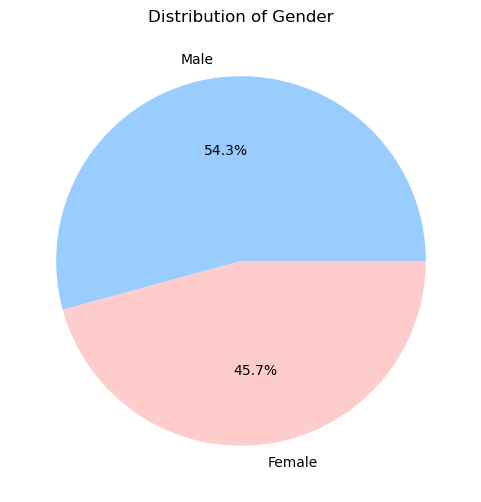

In [13]:
#Filter out entries with gender 'o'
df_cd = df_cd[df_cd['gender'] != 'o']

# Calculate the distribution of genders after filtering
gender_distribution = df_cd['gender'].value_counts()

gender_labels = {'f': 'Female', 'm': 'Male'}

# Plotting the distribution as a pie chart
plt.figure(figsize=(6, 6))
plt.pie(gender_distribution, labels=gender_distribution.index.map(gender_labels), autopct='%1.1f%%', colors=['#99ccff', '#ffcccc'])

# Adding a title
plt.title('Distribution of Gender')

# Displaying the plot
plt.show()

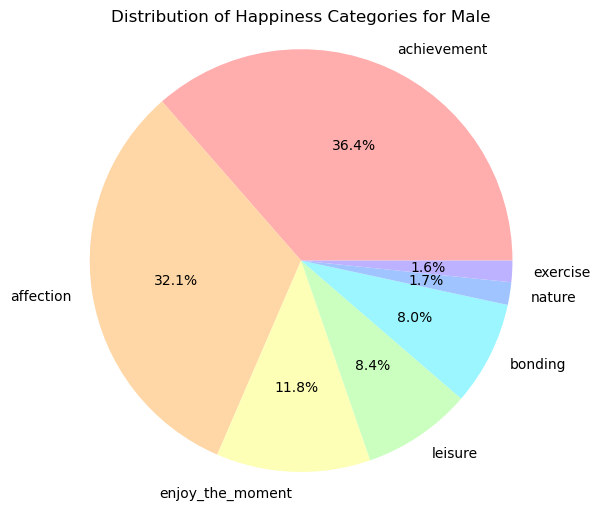

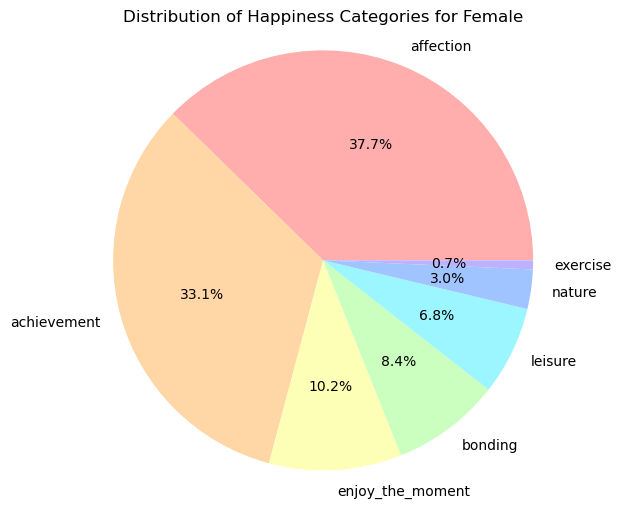

In [28]:
# Filter dataframe for male and female separately
male_df = df_cd[df_cd['gender'] == 'm']
female_df = df_cd[df_cd['gender'] == 'f']

# Calculate the distribution of happiness categories for male and female
male_category_distribution = male_df['predicted_category'].value_counts()
female_category_distribution = female_df['predicted_category'].value_counts()

# Define custom colors for the slices
colors = ['#ffadad', '#ffd6A5', '#fdffb6', '#caffbf', '#9bf6ff', '#a0c4ff', '#bdb2ff']

# Plotting the distribution for male as a pie chart
plt.figure(figsize=(6, 6))
plt.pie(male_category_distribution, labels=male_category_distribution.index, autopct='%1.1f%%', colors=colors)
plt.title('Distribution of Happiness Categories for Male')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

# Plotting the distribution for female as a pie chart
plt.figure(figsize=(8, 6))
plt.pie(female_category_distribution, labels=female_category_distribution.index, autopct='%1.1f%%', colors=colors)
plt.title('Distribution of Happiness Categories for Female')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()


Based on the charts, we observe minimal disparity among the categories, and the order of categories appears consistent between men and women in terms of what contributes to their happiness (these are happiness categories). However, among childfree married men, achievement appears to play a more significant role in contributing to their happiness, followed by affection. Conversely, for women, affection takes precedence over achievement in terms of its contribution to their overall happiness.

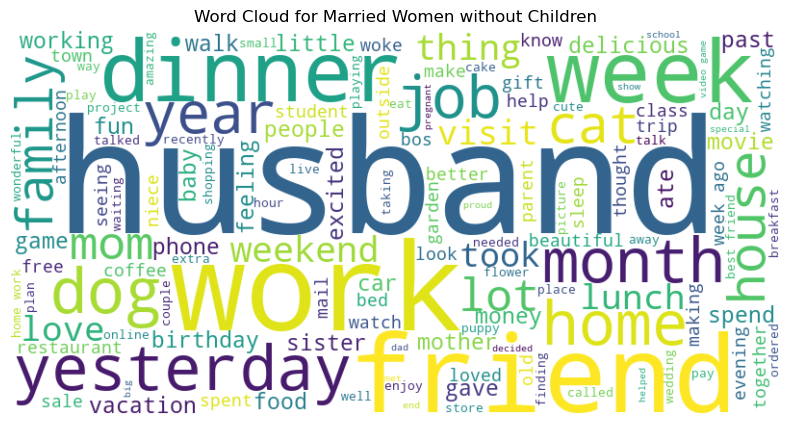

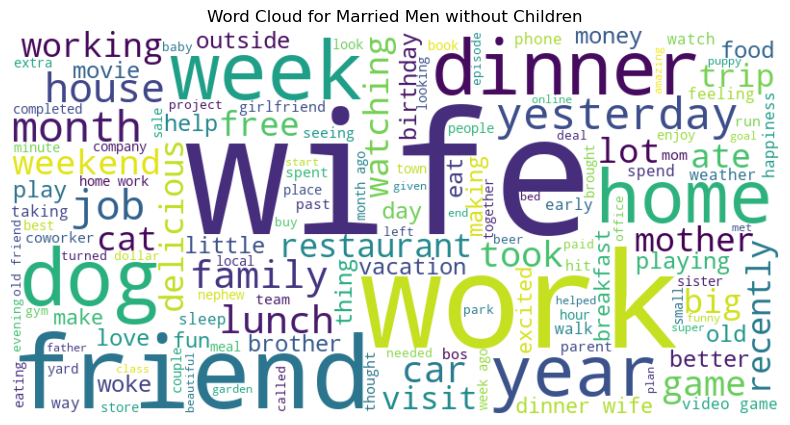

In [48]:
# Define custom stopwords
custom_stopwords = ['happy', 'felt', 'got', 'bit', 'good', 'day', 'time', 'watched', 'feel', 'enjoyed', 'able', 'found', 'played', 'finally', 'moment', 'night', 'said', 'saw',
                    'life', 'came', 'wanted', 'went', 'nice', 'bought', 'event', 'going', 'favorite', 'morning', 'told', 'great', 'make', 'today', 'new', 'getting', 'received', 'long', 'started', 'finished', 'hours']
all_stopwords = set(stopwords.words('english') + custom_stopwords)

# Function to create word cloud
def create_word_cloud(text, title):
    # Preprocess text
    processed_text = strip_numeric(strip_punctuation(strip_short(remove_stopwords(text.lower()), minsize=3)))
    # Tokenize the text
    words = word_tokenize(processed_text)
    # Remove stopwords
    words = [word for word in words if word not in all_stopwords]
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    # Join the words back into a single string
    filtered_text = ' '.join(words)
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', min_font_size=10).generate(filtered_text)
    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis("off")
    plt.show()

# Filter dataframe for female and create word cloud
female_text = ' '.join(df_cd[df_cd['gender'] == 'f']['cleaned_hm'])
create_word_cloud(female_text, "Word Cloud for Married Women without Children")

# Filter dataframe for male and create word cloud
male_text = ' '.join(df_cd[df_cd['gender'] == 'm']['cleaned_hm'])
create_word_cloud(male_text, "Word Cloud for Married Men without Children")
